# 🧪 01b - Monitor Image ETL Quality
This notebook checks for image quality issues after the ETL process such as unreadable files, invalid dimensions, or corrupted images.

In [ ]:
from google.colab import auth
auth.authenticate_user()

import os
import io
import pandas as pd
from PIL import Image, UnidentifiedImageError
from google.cloud import storage
from tqdm import tqdm


In [ ]:

project_id = "exalted-summer-454012-d2"
bucket_name = "boothill2001-dataset"
image_prefix = "flickr_image_dataset/processed/"


In [ ]:

client = storage.Client(project=project_id)
bucket = client.bucket(bucket_name)
blobs = list(bucket.list_blobs(prefix=image_prefix))
image_blobs = [b for b in blobs if b.name.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"🖼️ Total images to check: {len(image_blobs)}")


🖼️ Total images to check: 31783


In [ ]:

log = []

for blob in tqdm(image_blobs):
    result = {
        "filename": blob.name,
        "status": "OK",
        "width": None,
        "height": None,
        "error": ""
    }
    try:
        image_data = blob.download_as_bytes()
        image = Image.open(io.BytesIO(image_data))
        result["width"], result["height"] = image.size

        if image.size != (224, 224):
            result["status"] = "INVALID_DIMENSION"
            result["error"] = f"Got size {image.size}"
    except UnidentifiedImageError:
        result["status"] = "CORRUPTED"
        result["error"] = "UnidentifiedImageError"
    except Exception as e:
        result["status"] = "ERROR"
        result["error"] = str(e)

    log.append(result)

df_log = pd.DataFrame(log)
df_log.to_csv("image_etl_monitor_log.csv", index=False)
print("✅ Monitoring log saved to image_etl_monitor_log.csv")


100%|██████████| 31783/31783 [51:25<00:00, 10.30it/s]


✅ Monitoring log saved to image_etl_monitor_log.csv


In [ ]:

log_blob = bucket.blob("monitoring/image_etl_monitor_log.csv")
log_blob.upload_from_filename("image_etl_monitor_log.csv")
print("☁️ Uploaded monitoring log to GCS: monitoring/image_etl_monitor_log.csv")


☁️ Uploaded monitoring log to GCS: monitoring/image_etl_monitor_log.csv


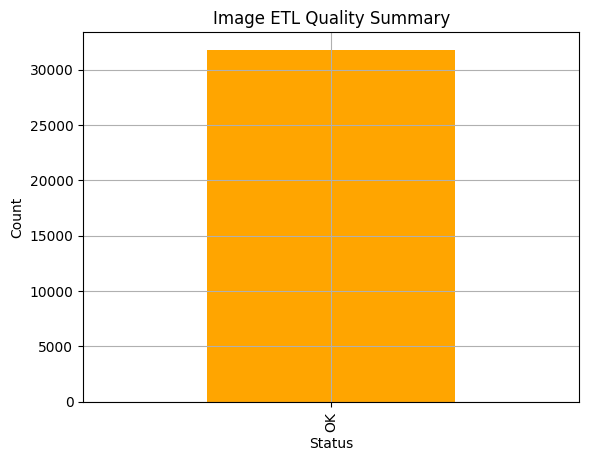

In [ ]:

import matplotlib.pyplot as plt

summary = df_log['status'].value_counts()
summary.plot(kind='bar', color='orange')
plt.title("Image ETL Quality Summary")
plt.xlabel("Status")
plt.ylabel("Count")
plt.grid(True)
plt.show()
